In [1]:
from pathlib import Path
import torch
import numpy as np
import random
from data import sample_latents
from vis import *
from models import *

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [2]:
D = [5, 5]
M = [[64, 64, 3], [64, 64, 3]]

z = sample_latents(D, "random", n_samples=10000)
z = scale_latents(z)

phi = ParallelSlots([SpriteworldRenderer(d_in, d_out) for d_in, d_out in zip(D, M)])
C = OccludeAdd()
f = CompositionalFunction(C, phi).to(dev)
f.eval()

CompositionalFunction(
  (composition): OccludeAdd()
  (slots): ParallelSlots(
    (slot_functions): ModuleList(
      (0-1): 2 x SpriteworldRenderer()
    )
  )
)

In [3]:
f_hat = UpsampleMLP(10, [64, 64, 3], d_hidden=320, n_channel=64).to(dev)

checkpoint = "/mnt/qb/work/bethge/twiedemer43/code/cood/_checkpoints/SW_rand_20230513-191248/latest.pt"

f_hat.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')))
f_hat.eval()

UpsampleMLP(
  (0): Linear(in_features=10, out_features=320, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=320, out_features=320, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=320, out_features=320, bias=True)
  (5): ELU(alpha=1.0)
  (6): Linear(in_features=320, out_features=1024, bias=True)
  (7): Unflatten(dim=1, unflattened_size=(64, 4, 4))
  (8): ELU(alpha=1.0)
  (9): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (10): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (11): ELU(alpha=1.0)
  (12): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (13): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (14): ELU(alpha=1.0)
  (15): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (16): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (17): ELU(alpha=1.0)
  (18): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
  (19): Conv2d(64, 3, kernel_size=(2, 2), stride=(1, 1), padding=s

NameError: name 'z' is not defined

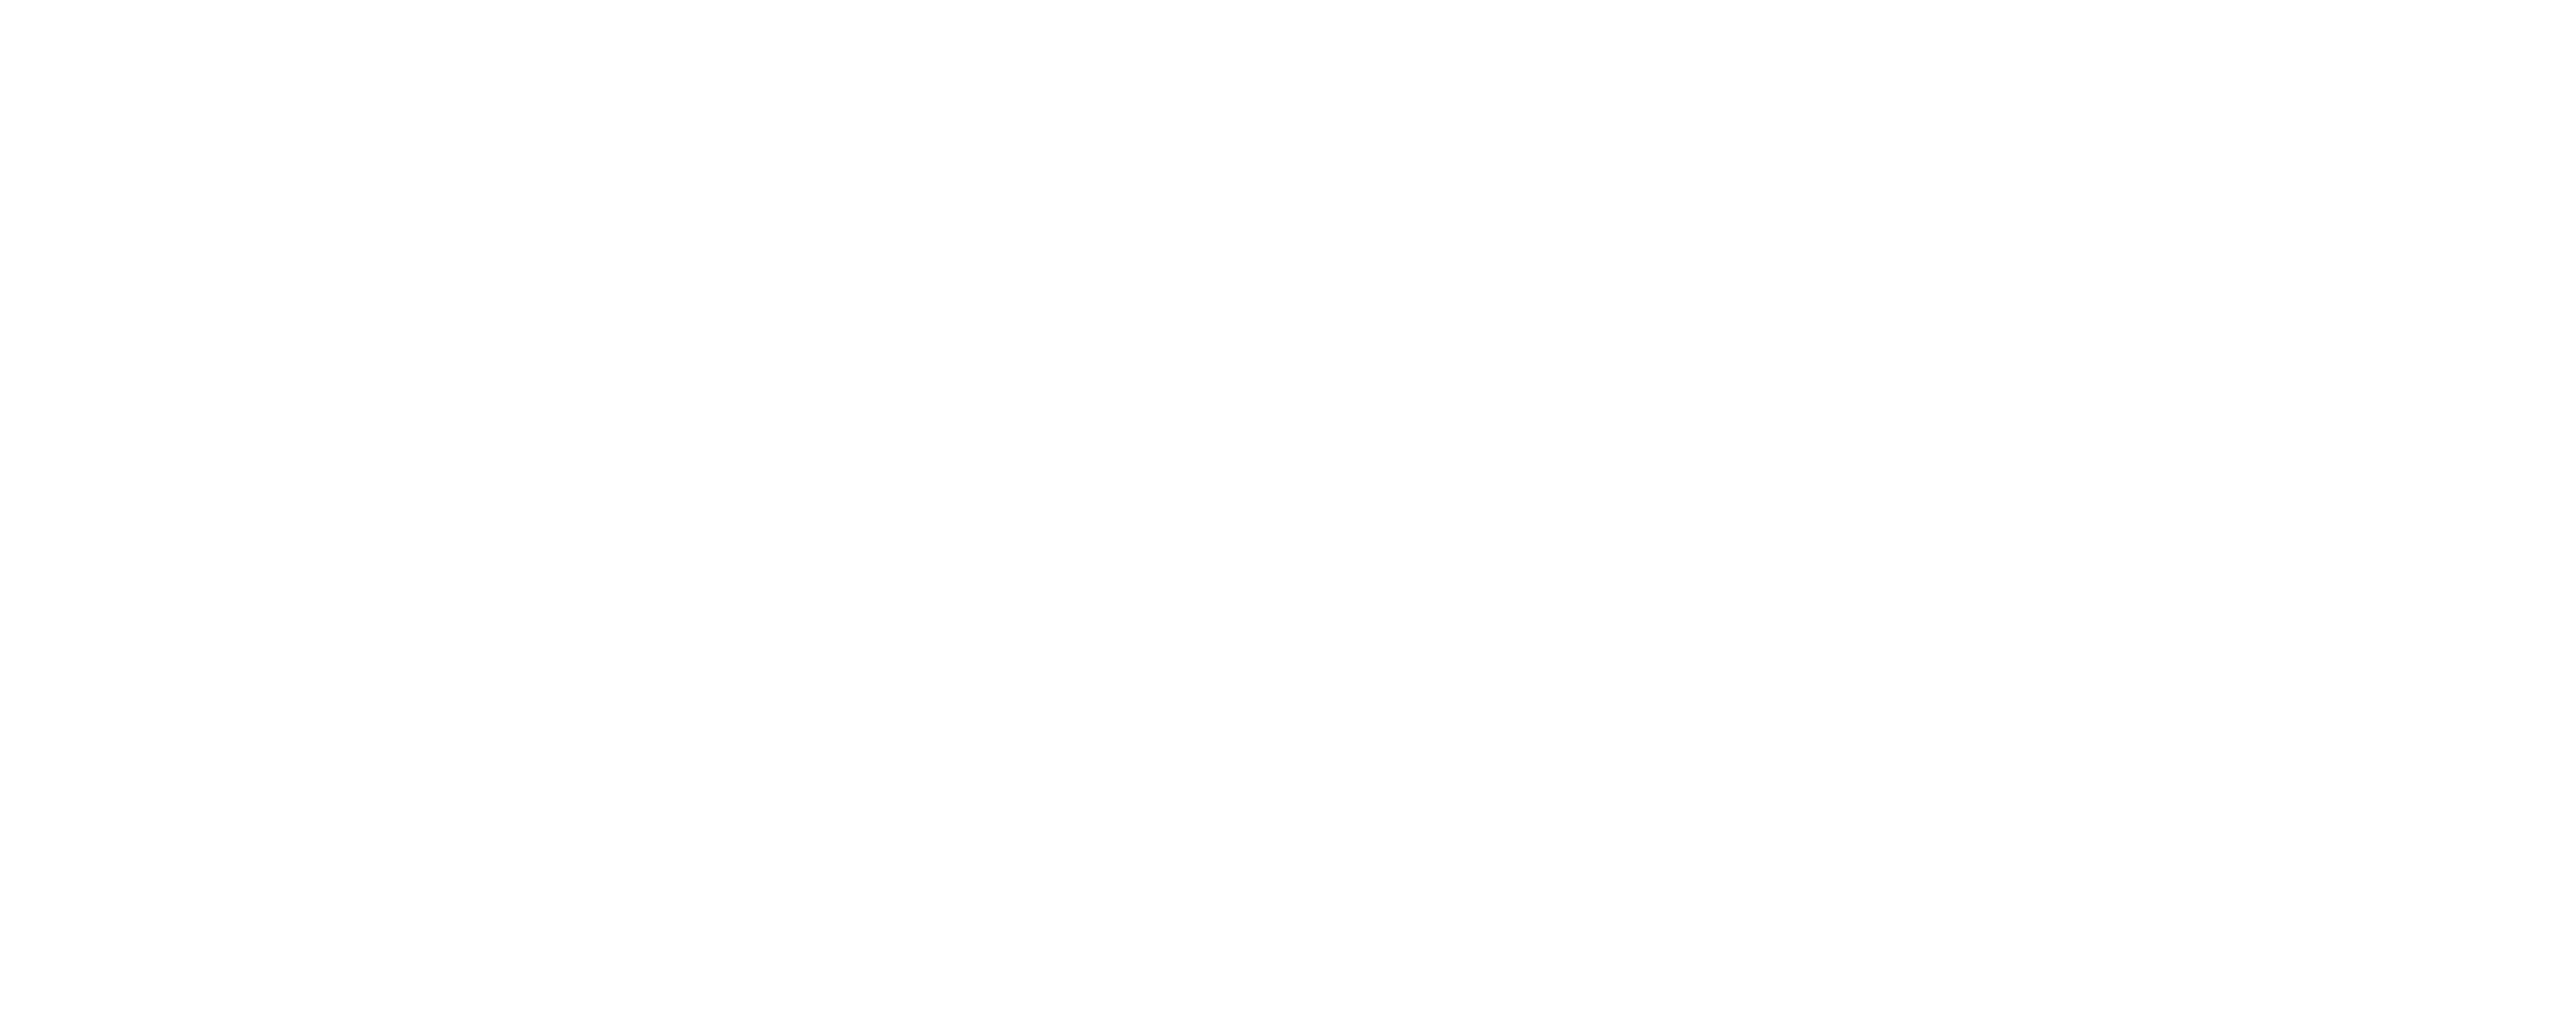

In [2]:
fig, axs = plt.subplots(6, 15, figsize=(15*3, 6*3))
[ax.axis("off") for ax in axs.ravel()]

for col, _z in enumerate(z[:15]):
    # target
    axs[0, col].imshow(f(_z.to(dev)).cpu().squeeze())

    # supports
    _z1 = torch.cat([scale_latents(torch.Tensor([0, 0, 0, 0, 0]).unsqueeze(0)).squeeze(), _z[5:]])
    _z2 = torch.cat([_z[:5], scale_latents(torch.Tensor([1, 1, 1, 0, 1]).unsqueeze(0)).squeeze()])
    axs[1, col].imshow(f(_z1.to(dev)).cpu().squeeze())
    axs[2, col].imshow(f(_z2.to(dev)).cpu().squeeze())

    # reconstructions
    axs[3, col].imshow(f_hat(_z.to(dev).unsqueeze(0)).cpu().squeeze().detach())
    axs[4, col].imshow(f_hat(_z1.to(dev).unsqueeze(0)).cpu().squeeze().detach())
    axs[5, col].imshow(f_hat(_z2.to(dev).unsqueeze(0)).cpu().squeeze().detach())

plt.savefig("fig1_samples.svg")


In [3]:
D = [5, 5]
M = [[64, 64, 3], [64, 64, 3]]

phi = ParallelSlots([SpriteworldRenderer(d_in, d_out) for d_in, d_out in zip(D, M)])
C = OccludeAdd(add="sigmoid")
f = CompositionalFunction(C, phi).to(dev)

phi1 = ParallelSlots([UpsampleMLP(d_in, d_out) for d_in, d_out in zip(D, M)])
f1 = CompositionalFunction(C, phi1).to(dev)

phi2 = ParallelSlots([UpsampleMLP(d_in, d_out) for d_in, d_out in zip(D, M)])
f2 = CompositionalFunction(C, phi2).to(dev)

checkpoint1 = "/mnt/qb/work/bethge/twiedemer43/code/cood/_checkpoints/SW_rand_20230513-091734/latest.pt"
checkpoint2 = "/mnt/qb/work/bethge/twiedemer43/code/cood/_checkpoints/SW_rand_20230514-000414/latest.pt"

f1.load_state_dict(torch.load(checkpoint1, map_location=torch.device('cpu')))
f2.load_state_dict(torch.load(checkpoint2, map_location=torch.device('cpu')))

f.eval()
f1.eval()
f2.eval()

CompositionalFunction(
  (composition): OccludeAdd()
  (slots): ParallelSlots(
    (slot_functions): ModuleList(
      (0-1): 2 x UpsampleMLP(
        (0): Linear(in_features=5, out_features=256, bias=True)
        (1): ELU(alpha=1.0)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ELU(alpha=1.0)
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): ELU(alpha=1.0)
        (6): Linear(in_features=256, out_features=512, bias=True)
        (7): Unflatten(dim=1, unflattened_size=(32, 4, 4))
        (8): ELU(alpha=1.0)
        (9): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
        (10): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (11): ELU(alpha=1.0)
        (12): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
        (13): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=same)
        (14): ELU(alpha=1.0)
        (15): UpsamplingBilinear2d(scale_factor=2.0, mode='bilinear')
 

In [61]:
sb.set_theme("notebook", "whitegrid")

z = sample_latents(D, "grid", n_samples=10000, grid_size=17)
z = scale_latents(z)

mse1 = torch.Tensor()
mse2 = torch.Tensor()
for _z in z.split(10):
    with torch.no_grad():
        x = f(_z).flatten(1)
        x1 = f1(_z).flatten(1)
        x2 = f2(_z).flatten(1)

        _mse1 = (x1 - x).pow(2).mean(dim=-1)
        _mse2 = (x2 - x).pow(2).mean(dim=-1)

        mse1 = torch.cat([mse1, _mse1], dim=0)
        mse2 = torch.cat([mse2, _mse2], dim=0)

latents = torch.stack([z[:, 0], z[:, 5]], dim=1)

In [62]:
combined_data = torch.cat([latents, mse1.unsqueeze(1), mse2.unsqueeze(1)], dim=1)

cols = ["component 1 x", "component 2 x", "no gap", "gap"]
df = pd.DataFrame(combined_data.numpy(), columns=cols)

df_view = df.groupby(cols[:2]).mean()
vmin = min(df_view.min())
vmax = max(df_view.max())
df_view = df_view.reset_index().pivot(columns=cols[0], index=cols[1], values=cols[2:])

In [143]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5.2, 3))
cbar_ax = fig.add_axes([1, .265, .03, .675])

sb.heatmap(df_view["no gap"], vmin=vmin, vmax=vmax, cmap="mako", cbar=False, ax=axs[0])
sb.heatmap(df_view["gap"], vmin=vmin, vmax=vmax, cmap="mako", ax=axs[1], cbar_ax=cbar_ax)

# correct the tick labels
labels = [f"{a:.1f}" for a in np.arange(0.1, 1, 0.1)]
for ax in axs:
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
axs[0].invert_yaxis()
axs[1].set_ylabel("")

# add label to colorbar
plt.figtext(1, .2, "MSE")

plt.tight_layout()

/tmp/ipykernel_3753847/3589082234.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [68]:
axs[0]

<Axes: xlabel='component 1 x', ylabel='component 2 x'>